In [1]:
%cd ../

/home/users/dmoreno2016/VisionTransformers


In [2]:
import os
import webdataset as wds
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import torch

import random

In [22]:
# Path to your shards directory
#shards_path = f'data/images/minmax_tensors_bands6_grid_224/plasticc/{subset}/fold_{fold}'
#shards_path = f'data/images/alcock/20/minmax_by_obj_256/train/fold_0'
shards_path = f'data/images/macho/all/minmax_by_obj_256/test/fold_0'

# List all tar files in the directory
shard_files = [f for f in os.listdir(shards_path) if f.endswith(".tar.gz")]
# Get the number of shard files (assuming they are numbered sequentially)
if shard_files:
    min_index = min(int(f.split('-')[1].split('.')[0]) for f in shard_files)
    max_index = max(int(f.split('-')[1].split('.')[0]) for f in shard_files)
    dataset_url = f"{shards_path}/imgs_lc-{{{min_index:06d}..{max_index:06d}}}.tar.gz"
    print(f"Dataset URL: {dataset_url}")
else:
    print("No shard files found in the directory.")

def fn_decode(sample):
    for key, value in sample.items():
        if key.endswith(".pth"):
            sample[key] = torch.load(io.BytesIO(value), weights_only=True)
        elif key.endswith(".txt"):
            sample[key] = value.decode("utf-8") 
        elif key.endswith(".cls"):
            try:
                sample[key] = int(value) 
            except:
                pass
    return sample

dataset = (
    wds.WebDataset(dataset_url)
    .map(lambda sample: fn_decode(sample))
    #.shuffle(10000)
)

Dataset URL: data/images/macho/all/minmax_by_obj_256/test/fold_0/imgs_lc-{000000..000015}.tar.gz


In [23]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

for i, batch_0 in enumerate(dataloader):
    print(batch_0['label.cls'])
    break

[b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan', b'nan']


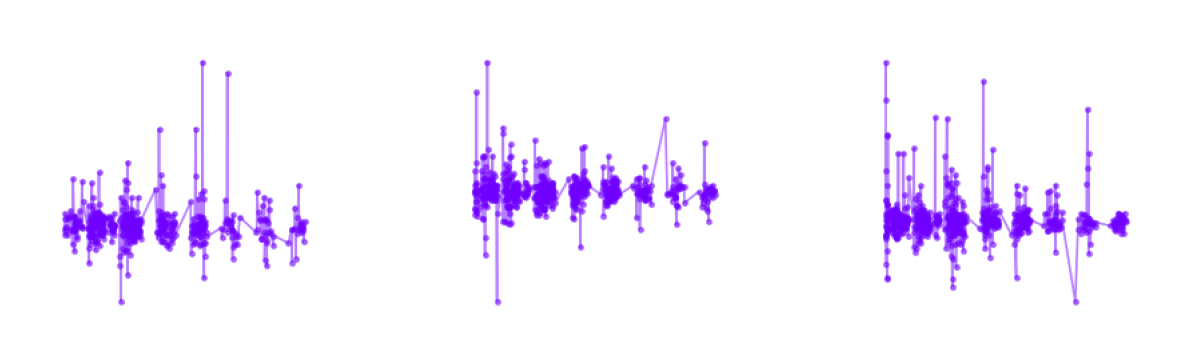

In [57]:
num_images = batch_0['pixel_values.pth'].squeeze(1).shape[0]
random_indices = random.sample(range(num_images), 3)
images = [batch_0['pixel_values.pth'].squeeze(1)[i] for i in random_indices]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(images[i])
    ax.axis('off')  

plt.show()

In [36]:
dict_mapping_classes = {
  'RR lyrae': 0,
  'AGN': 1,
  'SNII': 2,
  'SNIa': 3,
  'M-dwarf': 4,
  'Eclip. Binary': 5,
  'SNIa-91bg': 6,
  'SLSN-I': 7,
  'SNIbc': 8,
  'TDE': 9,
  'SNIax': 10,
  'Single u-lens': 11,
  'Kilonova': 12,
  'Mira': 13,
}

reverse_dict_mapping_classes = {v: k for k, v in dict_mapping_classes.items()}

In [43]:
import torch
from collections import defaultdict

# Inicializar un diccionario para contar los objetos por clase
class_counts = defaultdict(int)

# Recorre todos los lotes en el DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)
for batch in dataloader:
    # Accede a los labels del batch
    labels = batch['label.cls']  # Asegúrate de usar la clave correcta

    # Cuenta el número de objetos por clase en el lote actual
    for label in labels:
        class_name = reverse_dict_mapping_classes.get(label.item(), 'Desconocida')
        class_counts[class_name] += 1

In [44]:
import pandas as pd

class_counts_series = pd.Series(class_counts)
class_counts_series

AGN               762
SNIa             9483
M-dwarf          1214
SNII             5552
SNIa-91bg         352
SLSN-I            303
SNIbc            1192
Eclip. Binary    1184
SNIax             440
Single u-lens     125
TDE               459
RR lyrae         1098
Mira               32
Kilonova           82
dtype: int64

In [45]:
dict_mapping_real_classes = {
    6: 'Single u-lens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
}

In [46]:
ordered_series = class_counts_series.reindex(dict_mapping_real_classes.values())
ordered_series

Single u-lens     125
TDE               459
Eclip. Binary    1184
SNII             5552
SNIax             440
Mira               32
SNIbc            1192
Kilonova           82
M-dwarf          1214
SNIa-91bg         352
AGN               762
SNIa             9483
RR lyrae         1098
SLSN-I            303
dtype: int64

In [47]:
import matplotlib.pyplot as plt

def plot_count_classes_vertical(data, ylim, title, color=None, use_percentage=False):

    fs = 24
    tick_fs = 24

    # Nombres de las categorías y sus valores
    categories = [str(x) for x in data.keys()]
    values = list(data.values)

    # Crear el gráfico de barras
    plt.figure(figsize=(20, 8))
    if color is None:
        bars = plt.bar(categories, values)
    else:
        bars = plt.bar(categories, values, color=color)

    # Añadir los valores arriba de cada barra
    #for bar in bars:
    #    yval = bar.get_height()
    #    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.05, round(yval, 2), 
    #             va='bottom', ha='center', fontsize=fs+2, rotation=90)

    total_orig = data.sum()
    for bar in bars:
        height = bar.get_height()
        if use_percentage:
            percentage = (height / total_orig) * 100
            text = f"{height:,.0f} ({percentage:.2f}%)"
        else:
            text = f"{height:,.0f}"
            
        text_position = height + (ylim[1] - ylim[0]) * 0.02  # Ajustar el 0.02 según sea necesario para el offset
        plt.text(bar.get_x() + bar.get_width()/2, text_position, 
                 text, ha='center', va='bottom', fontsize=fs, rotation=90)
        
        #plt.text(bar.get_x() + bar.get_width()/2, height * 1.05, 
        #        text, ha='center', va='bottom', fontsize=fs, rotation=90)

    # Títulos y etiquetas
    plt.title('{}'.format(title), fontsize=fs+4, pad=15)
    plt.xlabel('Classes', fontsize=fs)
    plt.ylabel('Count', fontsize=fs)

    # Ajustar el tamaño de los ticks
    plt.xticks(fontsize=tick_fs, rotation=90)
    plt.yticks(fontsize=tick_fs)

    #plt.yscale('log')
    plt.ylim(ylim)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

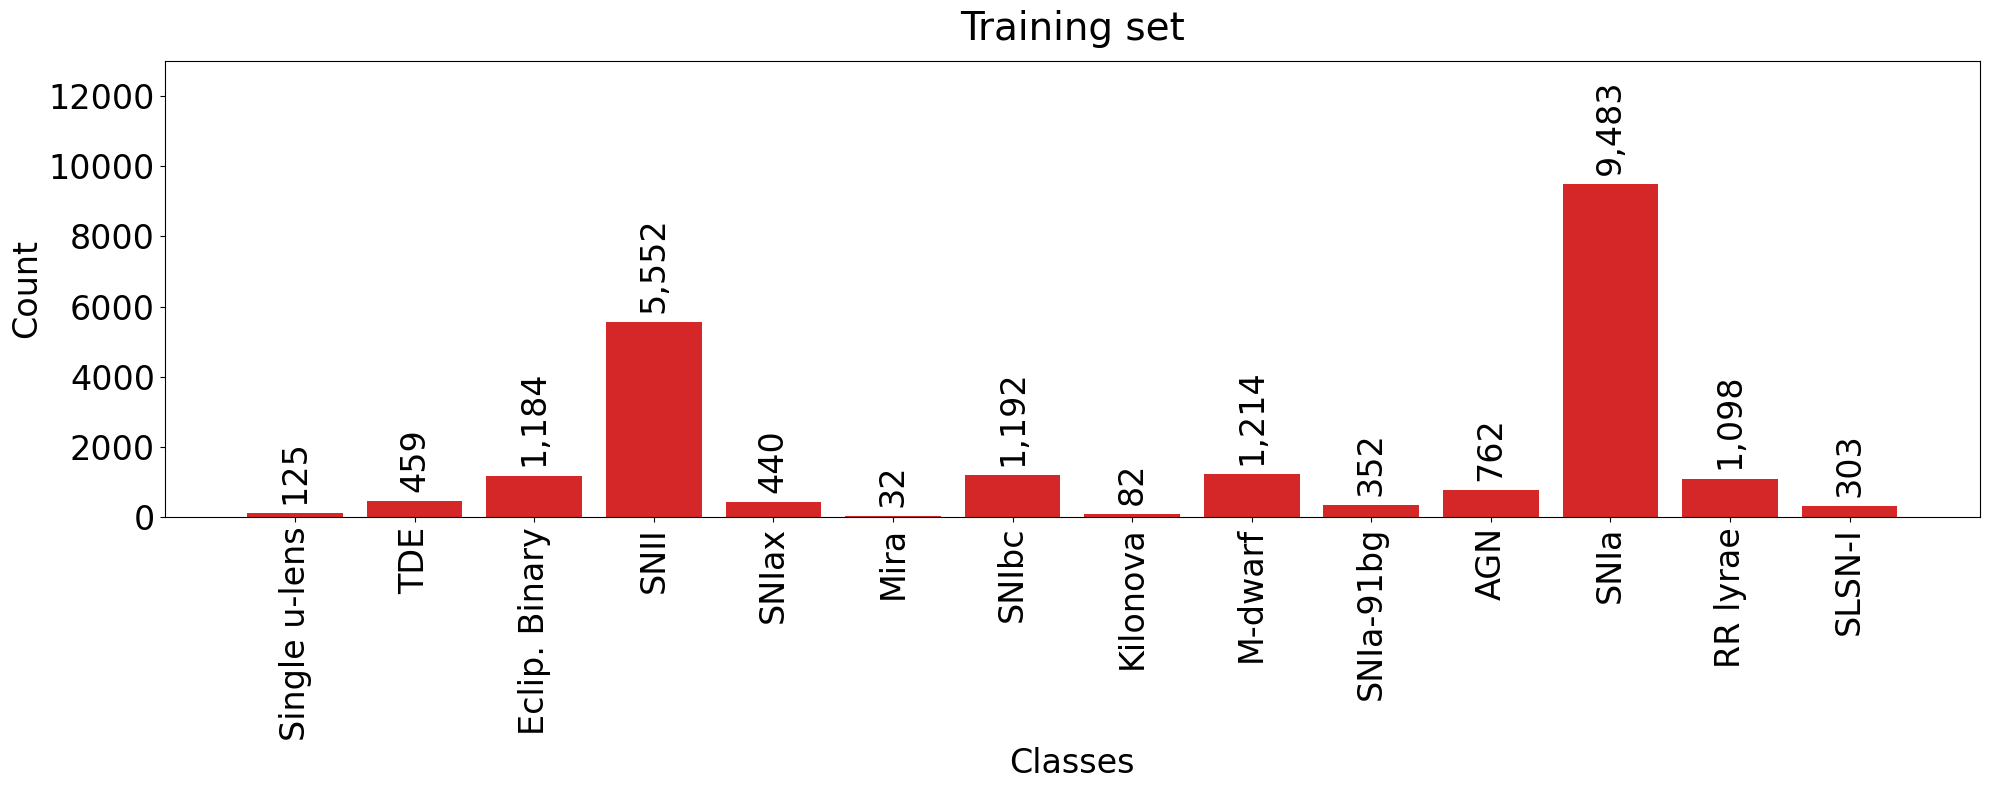

In [51]:
plot_count_classes_vertical(ordered_series, ylim=(0, 13000), title='Training set', color='tab:red', use_percentage=False)

In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

for i, batch_0 in enumerate(dataloader):
    break

In [32]:
batch_0.keys()

dict_keys(['__key__', '__url__', 'id.txt', 'label.cls', 'pixel_values.pth'])

In [33]:
batch_0['pixel_values.pth'].shape

torch.Size([64, 1, 256, 256, 3])

In [34]:
batch_0['pixel_values.pth'].squeeze(1).shape

torch.Size([64, 256, 256, 3])

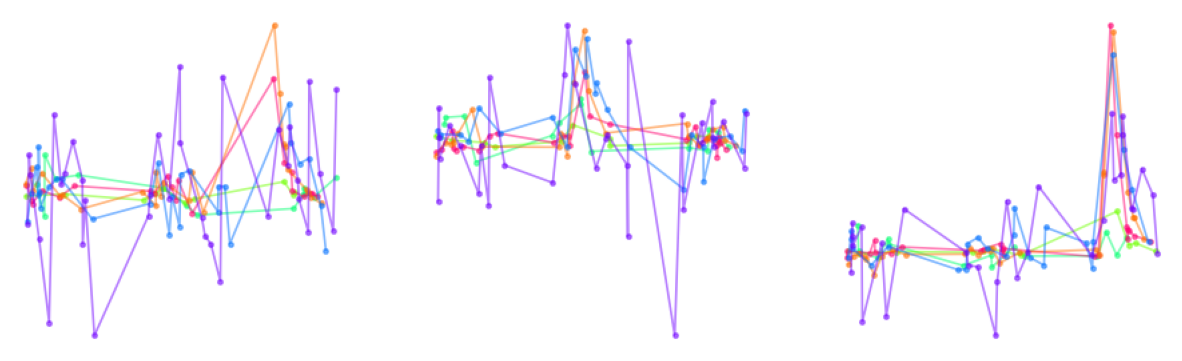

In [35]:
num_images = batch_0['pixel_values.pth'].squeeze(1).shape[0]
random_indices = random.sample(range(num_images), 3)
images = [batch_0['pixel_values.pth'].squeeze(1)[i] for i in random_indices]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(images[i])
    ax.axis('off') 

plt.show()

Dataset URL: data/images/plasticc/minmax_by_obj_256_6band_hexadecimal/val/fold_0/imgs_lc-{000000..000000}.tar.gz


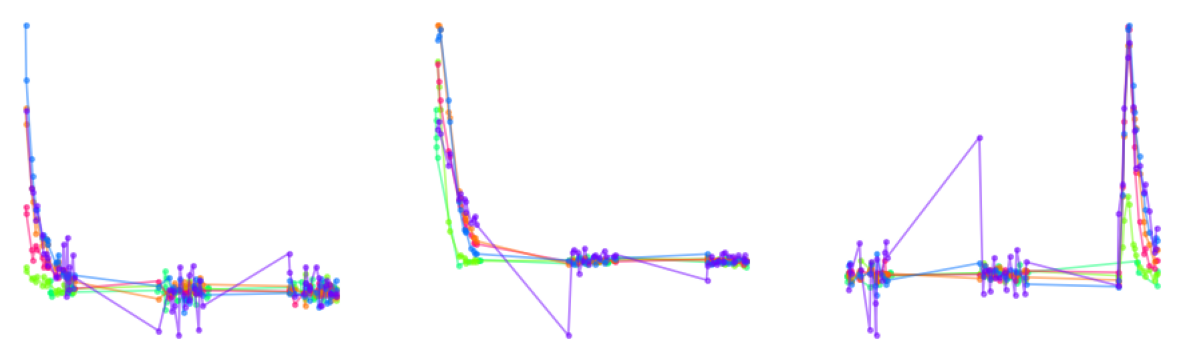

In [29]:
# Path to your shards directory
#shards_path = f'data/images/minmax_tensors_bands6_grid_224/plasticc/{subset}/fold_{fold}'
shards_path = f'data/images/plasticc/minmax_by_obj_256_6band_hexadecimal/val/fold_0'

# List all tar files in the directory
shard_files = [f for f in os.listdir(shards_path) if f.endswith(".tar.gz")]
# Get the number of shard files (assuming they are numbered sequentially)
if shard_files:
    min_index = min(int(f.split('-')[1].split('.')[0]) for f in shard_files)
    max_index = max(int(f.split('-')[1].split('.')[0]) for f in shard_files)
    dataset_url = f"{shards_path}/imgs_lc-{{{min_index:06d}..{max_index:06d}}}.tar.gz"
    print(f"Dataset URL: {dataset_url}")
else:
    print("No shard files found in the directory.")

def fn_decode(sample):
    for key, value in sample.items():
        if key.endswith(".pth"):
            sample[key] = torch.load(io.BytesIO(value), weights_only=True)
        elif key.endswith(".txt"):
            sample[key] = value.decode("utf-8") 
        elif key.endswith(".cls"):
            sample[key] = int(value) 
    return sample

dataset = (
    wds.WebDataset(dataset_url)
    .map(lambda sample: fn_decode(sample))
    #.shuffle(10000)
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

for i, batch_0 in enumerate(dataloader):
    break

num_images = batch_0['pixel_values.pth'].squeeze(1).shape[0]
random_indices = random.sample(range(num_images), 3)
images = [batch_0['pixel_values.pth'].squeeze(1)[i] for i in random_indices]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.imshow(images[i])
    ax.axis('off') 

plt.show()